In [1]:
import torch
from torch import nn
class SoftmaxWeight(nn.Module):
    def __init__(self, K, p, hidden_dimensions =[]):
        super().__init__()
        self.K = K
        self.p = p
        self.network_dimensions = [self.p] + hidden_dimensions + [self.K]
        network = []
        for h0, h1 in zip(self.network_dimensions, self.network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1),nn.Tanh(),])
        network.pop()
        self.f = nn.Sequential(*network)
        self.f[-1].bias = nn.Parameter(torch.ones(self.K))
        self.f[-1].weight = nn.Parameter(torch.zeros_like(self.f[-1].weight))

    def log_prob(self, z):
        unormalized_log_w = self.f.forward(z)
        return unormalized_log_w - torch.logsumexp(unormalized_log_w, dim=-1, keepdim=True)

In [2]:
from IPython.display import clear_output
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
###MNIST###
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
fmnist_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
fmnist_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
total_samples = torch.cat([torch.tensor(fmnist_trainset.data).flatten(start_dim=1).float(),torch.tensor(fmnist_testset.data).flatten(start_dim=1).float()])
#50000 train_set
#10000 test_set
total_samples=(total_samples + torch.rand_like(total_samples))/256
total_labels = torch.cat([torch.tensor(fmnist_trainset.targets), torch.tensor(fmnist_testset.targets)])

extracted_0=total_samples[total_labels ==0]
extracted_1=total_samples[total_labels ==1]

num_to_switch = 600
train_samples = torch.cat([extracted_0[num_to_switch:], extracted_1[:num_to_switch]])
train_labels = torch.cat([torch.zeros(extracted_0.shape[0]-num_to_switch), torch.ones(num_to_switch)]).long()

randperm = torch.randperm(extracted_0.shape[0])
testval_samples = torch.cat([extracted_1[num_to_switch:], extracted_0[:num_to_switch]])[randperm]
testval_labels = torch.cat([torch.ones(extracted_1.shape[0]-num_to_switch), torch.zeros(num_to_switch)])[randperm].long()

test_samples, val_samples = testval_samples[:3000],testval_samples[3000:]
test_labels, val_labels = testval_labels[:3000],testval_labels[3000:]

Files already downloaded and verified
Files already downloaded and verified


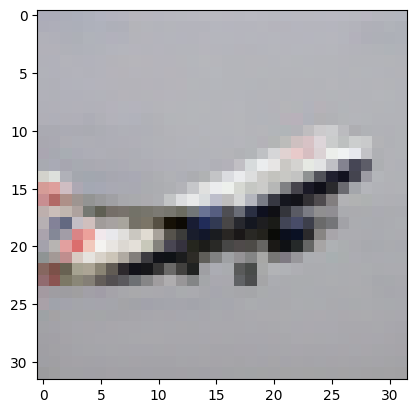

In [4]:
plt.imshow(train_samples[0].reshape(32,32,3))
plt.show()

In [5]:
from tqdm import tqdm

In [19]:
w = SoftmaxWeight(2,train_samples.shape[-1],[128,128])
optim = torch.optim.Adam(w.parameters(), lr = 1e-3)
list_accuracy = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_samples = train_samples.to(device)
train_labels = train_labels.to(device)

test_samples = test_samples.to(device)
test_labels = test_labels.to(device)

val_samples = val_samples.to(device)
val_labels = val_labels.to(device)

counts = torch.unique(train_labels, return_counts = True)[1]/train_labels.shape[0]
weights = torch.distributions.Dirichlet(torch.ones(train_labels.shape[0])).sample().to(device)
list_accuracy_train = []
list_accuracy_test = []
list_accuracy_val = []

w.to(device)
pbar = tqdm(range(500))
for t in pbar:
    optim.zero_grad()
    loss_train = -torch.sum(weights*(w.log_prob(train_samples))[range(train_samples.shape[0]),train_labels])
    with torch.no_grad():
        accuracy_train = torch.mean((torch.max(w.log_prob(train_samples), dim = 1)[1] == train_labels).float())
        list_accuracy_train.append(accuracy_train.cpu().item())
        accuracy_test = torch.mean((torch.max(w.log_prob(test_samples), dim = 1)[1] == test_labels).float())
        list_accuracy_test.append(accuracy_test.cpu().item())
        accuracy_val= torch.mean((torch.max(w.log_prob(val_samples), dim = 1)[1] == val_labels).float())
        list_accuracy_val.append(accuracy_val.cpu().item())
    loss_train.backward()
    optim.step()
    pbar.set_postfix_str('loss_train = ' + str(round(loss_train.item(),4)) +'; acc_train =' + str(round(accuracy_train.item(),4)) + '; acc_test =' + str(round(accuracy_test.item(),4)) + '; acc_val =' + str(round(accuracy_val.item(),4)))

100%|██████████████████████████████████████████| 500/500 [00:23<00:00, 21.32it/s, loss_train = 0.0247; acc_train =0.981; acc_test =0.524; acc_val =0.5277]


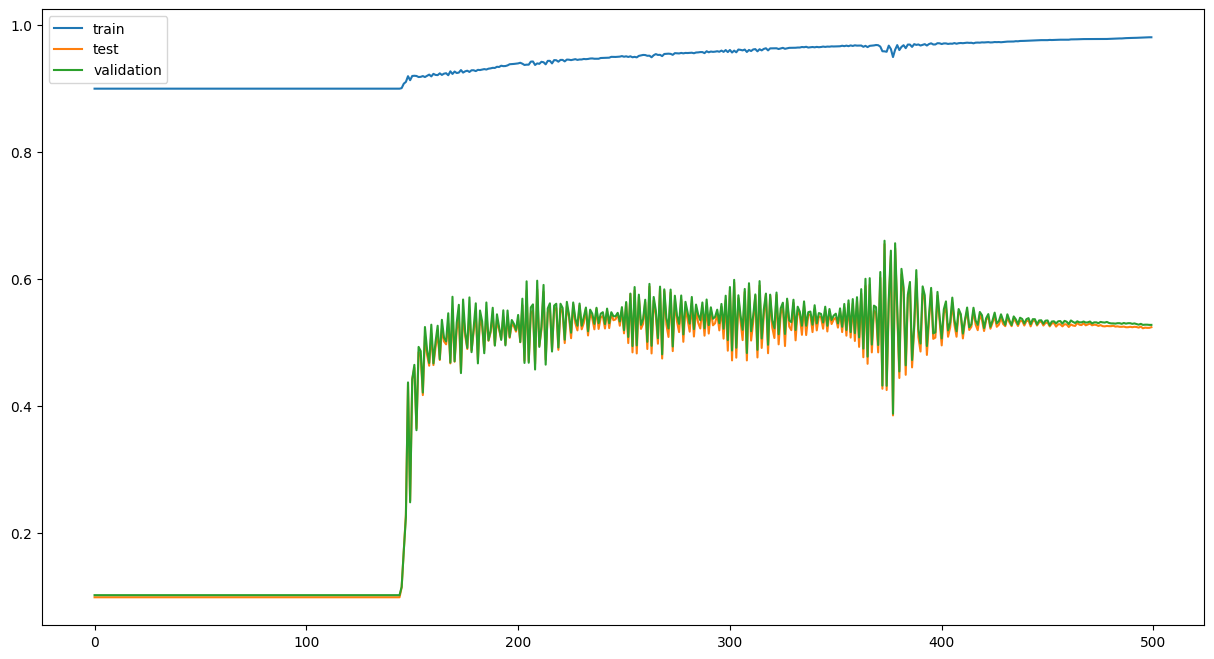

In [20]:
plt.figure(figsize = (15,8))
plt.plot(list_accuracy_train, label = 'train')
plt.plot(list_accuracy_test, label = 'test')
plt.plot(list_accuracy_val, label = 'validation')
plt.legend()
plt.show()

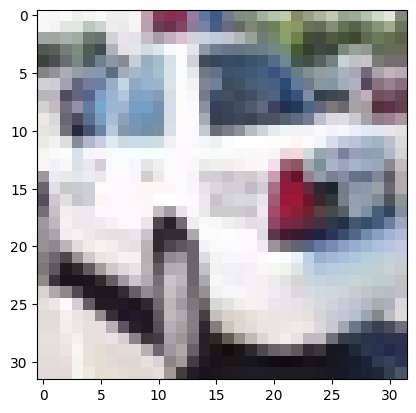

tensor([9.9965e-01, 3.4774e-04], device='cuda:0', grad_fn=<ExpBackward0>)


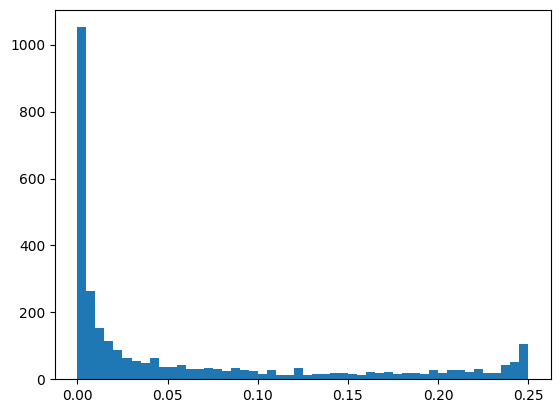

In [21]:
plt.imshow(test_samples[0].detach().cpu().numpy().reshape(32,32,3))
plt.show()
print(torch.exp(w.log_prob(test_samples[0])))
plt.hist(torch.prod(torch.exp(w.log_prob(test_samples)), dim = -1).cpu().detach().numpy(), bins = 50)
plt.show()

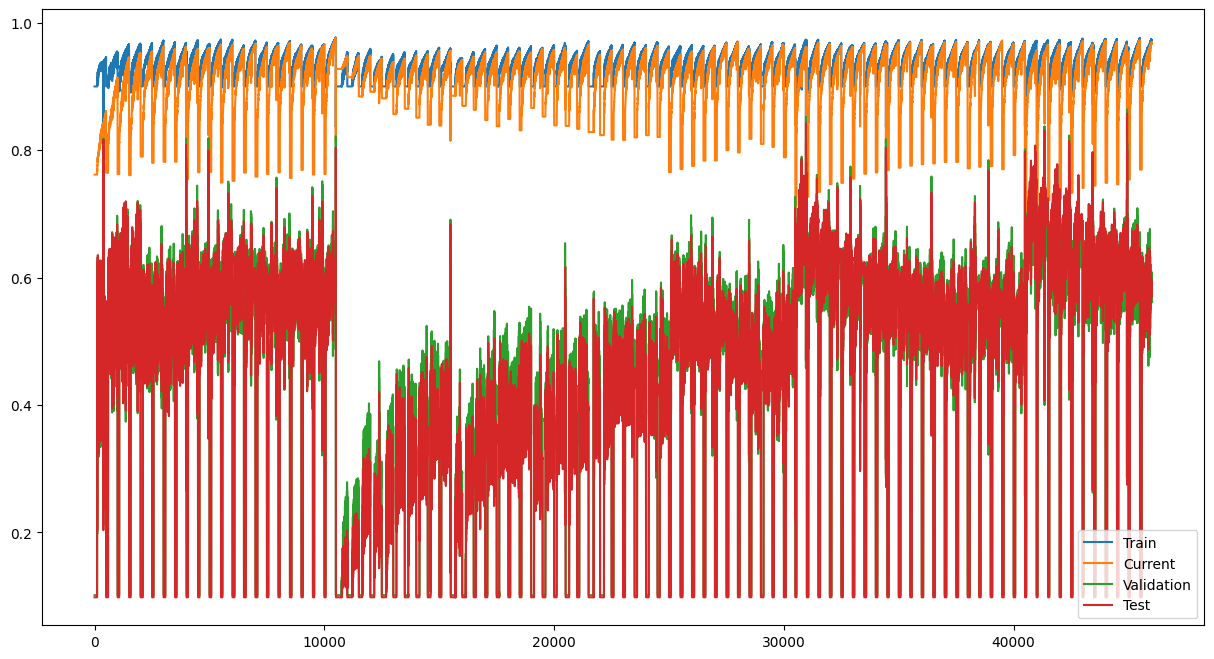

 92%|██████████████████▍ | 92/100 [14:43<00:53,  6.69s/it, loss_train = 0.2001; acc_current =0.9151; acc_train =0.9338; acc_test =0.6163; acc_val =0.6243]

In [22]:
list_accuracy_current_gibbs = []
list_accuracy_train_gibbs = []
list_accuracy_test_gibbs = []
list_accuracy_val_gibbs = []
pbar = tqdm(range(100))
log_prob_train_gibbs = []
log_prob_test_gibbs = []
log_prob_val_gibbs = []

w = SoftmaxWeight(2,train_samples.shape[-1],[128,128]).to(device)

current_samples = torch.cat([train_samples.to(device), test_samples.to(device)], dim = 0)
for i in pbar:
    fake_labels= torch.distributions.Categorical(torch.exp(w.to(device).log_prob(test_samples.to(device)))).sample()
    current_labels = torch.cat([train_labels.to(device), fake_labels], dim =0)
    counts = torch.unique(current_labels, return_counts = True)[1]/current_labels.shape[0]
    weights = torch.distributions.Dirichlet(torch.ones(current_labels.shape[0])).sample().to(device)
    w = SoftmaxWeight(2,train_samples.shape[-1],[128,128]).to(device)   
    optim = torch.optim.Adam(w.parameters(), lr = 1e-3)
    for t in range(500):
        optim.zero_grad()
        loss_train = -torch.sum(weights*(w.log_prob(current_samples))[torch.tensor(range(current_labels.shape[0])).to(device),current_labels])
        with torch.no_grad():
            accuracy_current = torch.mean((torch.max(w.log_prob(current_samples), dim = 1)[1] == current_labels).float())
            accuracy_val = torch.mean((torch.max(w.log_prob(val_samples), dim = 1)[1] == val_labels).float())
            accuracy_train = torch.mean((torch.max(w.log_prob(train_samples), dim = 1)[1] == train_labels).float())
            accuracy_test = torch.mean((torch.max(w.log_prob(test_samples), dim = 1)[1] == test_labels).float())
            list_accuracy_current_gibbs.append(accuracy_current.cpu().item())
            list_accuracy_train_gibbs.append(accuracy_train.cpu().item())
            list_accuracy_test_gibbs.append(accuracy_test.cpu().item())
            list_accuracy_val_gibbs.append(accuracy_val.cpu().item())
        loss_train.backward()
        optim.step()
        pbar.set_postfix_str('loss_train = ' + str(round(loss_train.item(),4))+'; acc_current =' + str(round(accuracy_current.item(),4)) +'; acc_train =' + str(round(accuracy_train.item(),4)) + '; acc_test =' + str(round(accuracy_test.item(),4)) + '; acc_val =' + str(round(accuracy_val.item(),4)))

    clear_output(wait = True)
    plt.hist(torch.prod(torch.exp(w.log_prob(test_samples)), dim = -1).cpu().detach().numpy(), bins = 50)
    plt.show()
    clear_output(wait = True)
    plt.figure(figsize = (15,8))
    plt.plot(list_accuracy_train_gibbs, label = 'Train')
    plt.plot(list_accuracy_current_gibbs, label ='Current')
    plt.plot(list_accuracy_val_gibbs, label = 'Validation')
    plt.plot(list_accuracy_test_gibbs, label = 'Test')
    plt.legend()
    plt.show()
    log_prob_train_gibbs.append(w.log_prob(train_samples))
    log_prob_test_gibbs.append(w.log_prob(test_samples))
    log_prob_val_gibbs.append(w.log_prob(val_samples))
bagging_log_prob_train_gibbs = torch.mean(torch.stack(log_prob_train_gibbs), dim =0)
bagging_log_prob_test_gibbs = torch.mean(torch.stack(log_prob_test_gibbs), dim =0)
bagging_log_prob_val_gibbs = torch.mean(torch.stack(log_prob_val_gibbs), dim =0)
bagging_accuracy_train= torch.mean((torch.max(bagging_log_prob_train_gibbs, dim = 1)[1] == train_labels).float())
print(bagging_accuracy_train)
bagging_accuracy_test = torch.mean((torch.max(bagging_log_prob_test_gibbs, dim = 1)[1] == test_labels).float())
print(bagging_accuracy_test)
bagging_accuracy_val= torch.mean((torch.max(bagging_log_prob_val_gibbs, dim = 1)[1] == val_labels).float())
print(bagging_accuracy_val)